# Define some paths

In [13]:
base_path = '/home/ec2-user/'
s3_base_path = base_path + 's3/'
s3_data_path = s3_base_path + 'data/'
s3_results_path = s3_base_path + 'results/'

s3_bucket_name = 'borowis-s3-us-east-1'

In [14]:
data_path = base_path + 's3/'
train_path = data_path + 'train/'
test_path = data_path + 'test/'
valid_path = data_path + 'valid/'
sample_path = data_path + 'sample/'

In [3]:
categories = ['c' + str(i) for i in range(10)]

# Imports

In [4]:
from utils import *
import vgg16; reload(vgg16)
from vgg16 import Vgg16

%matplotlib inline

/usr/lib64/python2.7/dist-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [6]:
from keras import backend as K

# Common functions

In [50]:
def plots_idx(base_path, idx, titles=None):
    plots([image.load_img(base_path + filenames[i]) for i in idx], titles=titles)

In [8]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# Command to sync with aws s3 bucket

In [90]:
!aws s3 sync $s3_base_path $s3_bucket_name


usage: aws [options] <command> <subcommand> [parameters]
aws: error: too few arguments


# Unzip data

In [63]:
!mkdir $data_path
!unzip -q $s3_data_path/statefarm.zip -d $data_path

file #1:  bad zipfile offset (local header sig):  0
file #2:  bad zipfile offset (local header sig):  35
file #3:  bad zipfile offset (local header sig):  41477


# Create sample/validation sets from statefarm data

Dataset size:

In [15]:
!ls -al $data_path/test/ | wc -l
for c in categories:
    !echo "$c: `ls -al $data_path/train/$c | wc -l`"

4
c0: 2042
c1: 1820
c2: 1870
c3: 1899
c4: 1879
c5: 1865
c6: 1878
c7: 1555
c8: 1464
c9: 1682


We have test / train set, now we need a validaton set and sample set

In [65]:
!mkdir $valid_path
for c in categories:
    !mkdir $valid_path/$c

!ls -al $valid_path

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 May  4 21:17 .
drwxrwxr-x  5 ec2-user ec2-user 4096 May  4 21:17 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:17 c9


In [66]:
!mkdir $sample_path
!mkdir $sample_path/train
!mkdir $sample_path/valid

for c in categories:
    !mkdir $sample_path/train/$c
    !mkdir $sample_path/valid/$c

In [16]:
!ls -al $sample_path/train

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 May  4 21:17 .
drwxrwxr-x  4 ec2-user ec2-user 4096 May  4 21:17 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c9


In [17]:
!ls -al $sample_path/valid

total 48
drwxrwxr-x 12 ec2-user ec2-user 4096 May  4 21:17 .
drwxrwxr-x  4 ec2-user ec2-user 4096 May  4 21:17 ..
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c0
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c1
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c2
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c3
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c4
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c5
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c6
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c7
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c8
drwxrwxr-x  2 ec2-user ec2-user 4096 May  4 21:18 c9


In [69]:
import random
import os
import shutil

def sample(base_path, destination_path, categories, sample_size, should_copy=True):
    func = shutil.copy if should_copy else shutil.move
    
    for category in categories:
        category_imgs = os.listdir(base_path + category)
        for category_img in random.sample(category_imgs, sample_size):
            func(base_path + category + '/' + category_img, destination_path + category)

In [70]:
SAMPLE_TRAIN_SIZE = 100
SAMPLE_VALID_SIZE = 25

sample(train_path, sample_path + 'train/', categories, SAMPLE_TRAIN_SIZE)
sample(train_path, sample_path + 'valid/', categories, SAMPLE_VALID_SIZE)

In [71]:
VALID_SIZE = 450

sample(train_path, valid_path, categories, VALID_SIZE, should_copy=False)

Prepare test set

In [72]:
!mkdir $test_path/unknown
!find $test_path -type f -iname '*.jpg' | xargs mv -t $test_path/unknown/

mv: ‘/home/ec2-user/data/test/unknown/img_33694.jpg’ and ‘/home/ec2-user/data/test//unknown/img_33694.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_11806.jpg’ and ‘/home/ec2-user/data/test//unknown/img_11806.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_69387.jpg’ and ‘/home/ec2-user/data/test//unknown/img_69387.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_30820.jpg’ and ‘/home/ec2-user/data/test//unknown/img_30820.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_3613.jpg’ and ‘/home/ec2-user/data/test//unknown/img_3613.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_20854.jpg’ and ‘/home/ec2-user/data/test//unknown/img_20854.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_96679.jpg’ and ‘/home/ec2-user/data/test//unknown/img_96679.jpg’ are the same file
mv: ‘/home/ec2-user/data/test/unknown/img_62028.jpg’ and ‘/home/ec2-user/data/test//unknown/img_62028.jpg’ are the same file
mv

In [77]:
!ls -al $test_path/unknown | wc -l

79727


In [82]:
!echo $data_path

/home/ec2-user/data/
/home/ec2-user/fast.ai/deeplearning1/nbs


In [89]:
!tar -cf $base_path/statefarm.tar -C $data_path sample/ test/ train/ valid/

# If you already have data

In [7]:
!mkdir $data_path
!tar -xf $s3_data_path/statefarm.tar -C $data_path

# Check directory structure

In [18]:
for c in categories:
    !echo "$c: `ls -al $train_path/$c | wc -l`"

c0: 2042
c1: 1820
c2: 1870
c3: 1899
c4: 1879
c5: 1865
c6: 1878
c7: 1555
c8: 1464
c9: 1682


In [19]:
for c in categories:
    !echo "$c: `ls -al $sample_path/valid/$c | wc -l`"

c0: 28
c1: 28
c2: 28
c3: 28
c4: 28
c5: 28
c6: 28
c7: 28
c8: 28
c9: 28


# Data exploration

In [23]:
n_view = 3
batch_size = 64
sample_val_batches = get_batches(sample_path + 'valid', shuffle=False, batch_size=1)
sample_batches = get_batches(sample_path + 'train', shuffle=False, batch_size=1)

Found 250 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [24]:
sample_val_classes = sample_val_batches.classes
sample_trn_classes = sample_batches.classes

sample_val_labels = onehot(sample_val_classes)
sample_trn_labels = onehot(sample_trn_classes)

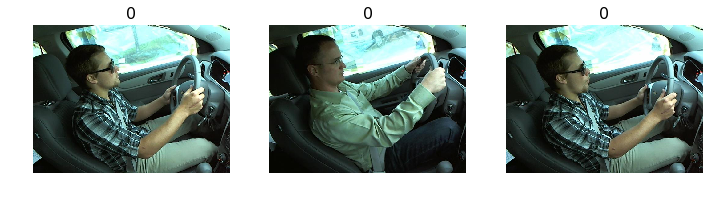

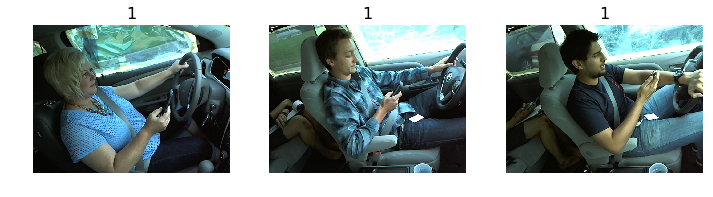

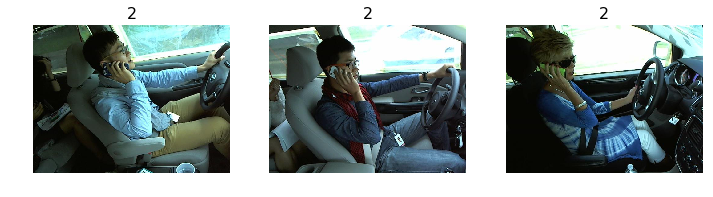

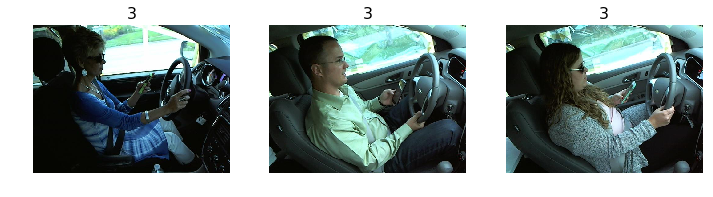

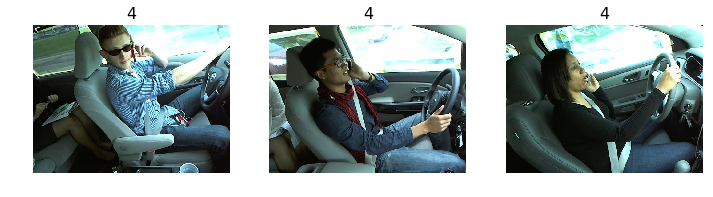

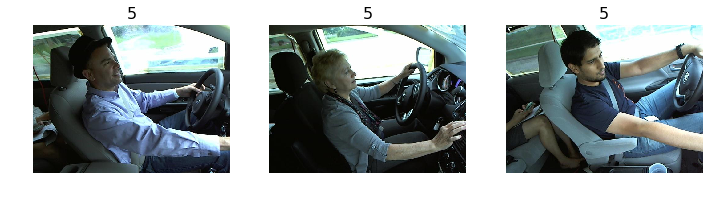

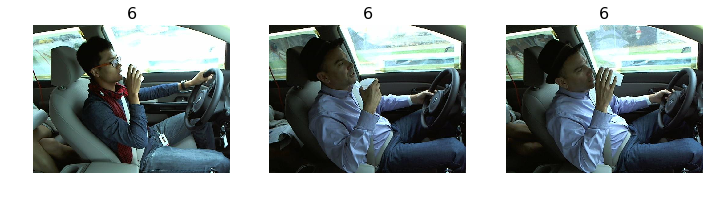

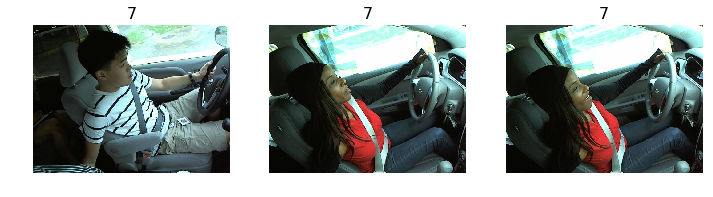

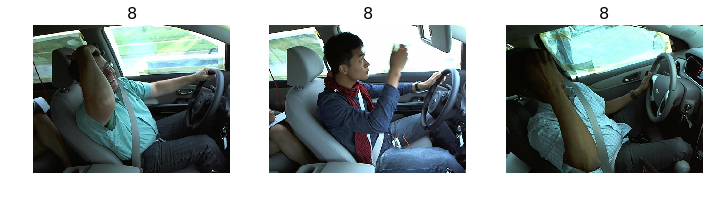

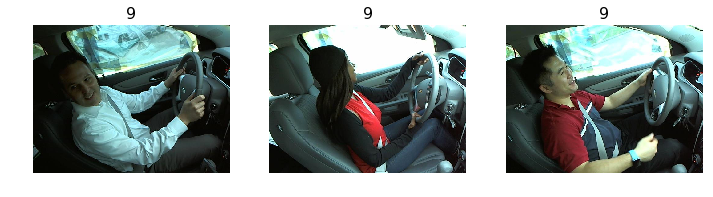

In [51]:
filenames = sample_val_batches.filenames
for i in range(len(categories)):
    plots_idx(sample_path + 'valid/', permutation(np.where(sample_val_classes == i)[0])[:n_view], [i] * n_view)

# Training on sample

In [26]:
sample_vgg = Vgg16()
sample_model = sample_vgg.model

In [27]:
sample_batch_size = 4
sample_val_batches = get_batches(sample_path + 'valid', shuffle=False, batch_size=sample_batch_size)
sample_batches = get_batches(sample_path + 'train', shuffle=True, batch_size=sample_batch_size)

Found 250 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [28]:
sample_model.pop()
for layer in sample_model.layers: layer.trainable=False
sample_model.add(Dense(10, activation='softmax'))

# sample_model.summary()

In [29]:
sample_opt = RMSprop(lr=0.001)
sample_model.compile(optimizer=sample_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
%%time
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 1)


CPU times: user 50 s, sys: 5.55 s, total: 55.6 s
Wall time: 3min 47s


In [32]:
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 3)

### Train more layers

In [36]:
sample_layers = sample_model.layers
first_dense_idx = [idx for idx, sample_layer in enumerate(sample_layers) if type(sample_layer) is Dense][0]

for sample_layer in sample_layers[first_dense_idx:]: sample_layer.trainable = True 

In [37]:
K.set_value(sample_opt.lr, 0.0001)

In [38]:
%%time
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 1)


CPU times: user 41.4 s, sys: 4.67 s, total: 46.1 s
Wall time: 29.3 s


### Train even more layers

In [46]:
for sample_layer in sample_layers[:12]: sample_layer.trainable = True

In [57]:
%%time
sample_vgg.fit(sample_batches, sample_val_batches, nb_epoch = 3)


CPU times: user 2min 3s, sys: 13.6 s, total: 2min 17s
Wall time: 1min 27s


### Now, try predictions

In [55]:
_, sample_preds = sample_vgg.test(sample_path + 'valid/', sample_batch_size)

Found 250 images belonging to 10 classes.


In [58]:
print ("Sample predictions\n%s" % np.clip(sample_preds[:10], 0.05, 0.95))

Sample predictions
[[ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.2937  0.05    0.05    0.392   0.0851  0.05    0.05    0.05    0.05    0.1911]
 [ 0.3706  0.4765  0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.0853]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.8197  0.05    0.05    0.05    0.05    0.05    0.0852  0.05    0.05    0.0597]
 [ 0.9198  0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]
 [ 0.95    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05    0.05  ]]


In [61]:
print (sample_val_batches.filenames[100:110])
print (sample_batch_size)
#for i in range(10):
#    plots_idx(sample_path + 'valid/', permutation(np.where(sample_val_classes == i)[0])[:n_view], [i] * n_view)

['c4/img_75683.jpg', 'c4/img_64670.jpg', 'c4/img_58147.jpg', 'c4/img_35688.jpg', 'c4/img_50781.jpg', 'c4/img_92005.jpg', 'c4/img_12204.jpg', 'c4/img_77239.jpg', 'c4/img_88178.jpg', 'c4/img_58436.jpg']
4


# Training on full dataset

In [49]:
vgg = Vgg16()
model = vgg.model

In [41]:
batch_size = 64
val_batches = get_batches(valid_path, shuffle=False, batch_size=batch_size)
batches = get_batches(train_path, shuffle=False, batch_size=batch_size)

Found 4500 images belonging to 10 classes.
Found 17924 images belonging to 10 classes.


In [53]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(10, activation='softmax'))

opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
%%time
vgg.fit(batches, val_batches, nb_epoch = 1)

Epoch 1/1
505s - loss: 14.3031 - acc: 0.1103 - val_loss: 14.5063 - val_acc: 0.1000
CPU times: user 12min 5s, sys: 1min 31s, total: 13min 36s
Wall time: 8min 33s


In [50]:
layers = model.layers
first_dense_idx = [idx for idx, layer in enumerate(layers) if type(layer) is Dense][0]

for layer in layers[first_dense_idx:]: layer.trainable = True 
    
K.set_value(opt.lr, 0.01)

In [51]:
%%time
vgg.fit(batches, val_batches, nb_epoch = 1)

RuntimeError: The model needs to be compiled before being used.